In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from utils import accuracy
from get_dataset import get_cifar100_data_loaders

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# CIFAR-100 数据加载器
cifar100_train_loader, cifar100_test_loader = get_cifar100_data_loaders(batch_size=256)

def finetune_resnet18(model, train_loader, test_loader, epochs=30, lr=0.001, weight_decay=0.00001):
    model.fc = torch.nn.Linear(512, 100)  
    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    top1_train_accuracy_list = []
    top1_accuracy_list = []
    top5_accuracy_list = []
    epoch_list = []

    for epoch in range(epochs):
        model.train()
        top1_train_accuracy = 0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            top1 = accuracy(logits, y_batch, topk=(1,))
            top1_train_accuracy += top1[0]

        top1_train_accuracy /= len(train_loader)
        model.eval()
        top1_accuracy = 0
        top5_accuracy = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                logits = model(x_batch)
                top1, top5 = accuracy(logits, y_batch, topk=(1, 5))
                top1_accuracy += top1[0]
                top5_accuracy += top5[0]

        top1_accuracy /= len(test_loader)
        top5_accuracy /= len(test_loader)

        top1_train_accuracy_list.append(top1_train_accuracy.item())
        top1_accuracy_list.append(top1_accuracy.item())
        top5_accuracy_list.append(top5_accuracy.item())
        epoch_list.append(epoch + 1)
        print(f"Epoch {epoch}\tTop1 Train accuracy {top1_train_accuracy.item()}\tTop1 Test accuracy: {top1_accuracy.item()}\tTop5 test acc: {top5_accuracy.item()}")

    return top1_train_accuracy_list, top1_accuracy_list, top5_accuracy_list, epoch_list

In [2]:

# 加载ImageNet预训练的ResNet-18
imagenet_resnet18 = torchvision.models.resnet18(pretrained=True)

# 微调 ImageNet 预训练的 ResNet-18
imagenet_top1_train_accuracy, imagenet_top1_test_accuracy, imagenet_top5_test_accuracy, epoch_list = finetune_resnet18(
    imagenet_resnet18, cifar100_train_loader, cifar100_test_loader)

/usr/local/miniconda3/envs/CV/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/miniconda3/envs/CV/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0	Top1 Train accuracy 33.91860580444336	Top1 Test accuracy: 41.591796875	Top5 test acc: 73.115234375
Epoch 1	Top1 Train accuracy 51.18183898925781	Top1 Test accuracy: 45.693359375	Top5 test acc: 76.2109375
Epoch 2	Top1 Train accuracy 60.75733184814453	Top1 Test accuracy: 43.271484375	Top5 test acc: 73.974609375
Epoch 3	Top1 Train accuracy 67.43103790283203	Top1 Test accuracy: 44.8046875	Top5 test acc: 73.61328125
Epoch 4	Top1 Train accuracy 72.24170684814453	Top1 Test accuracy: 42.080078125	Top5 test acc: 71.337890625
Epoch 5	Top1 Train accuracy 76.90010833740234	Top1 Test accuracy: 43.5546875	Top5 test acc: 72.890625
Epoch 6	Top1 Train accuracy 80.57078552246094	Top1 Test accuracy: 45.751953125	Top5 test acc: 74.169921875
Epoch 7	Top1 Train accuracy 84.19762420654297	Top1 Test accuracy: 46.025390625	Top5 test acc: 74.365234375
Epoch 8	Top1 Train accuracy 86.61830139160156	Top1 Test accuracy: 47.48046875	Top5 test acc: 74.677734375
Epoch 9	Top1 Train accuracy 89.03300476074219	To

In [3]:
# 加载通过自监督学习训练的 ResNet-18
checkpoint_path = '.logs/simclr_lr0.0001_wd0.001_bt512_e80/checkpoint_0080.pth.tar'
ssl_resnet18 = torchvision.models.resnet18(pretrained=False)
ssl_resnet18.fc = torch.nn.Linear(512, 100)  
checkpoint = torch.load(checkpoint_path, map_location=device)

# 加载自监督预训练权重
state_dict = checkpoint['state_dict']
for k in list(state_dict.keys()):
    if k.startswith('backbone.') and not k.startswith('backbone.fc'):
        state_dict[k[len("backbone."):]] = state_dict[k]
    del state_dict[k]
ssl_resnet18.load_state_dict(state_dict, strict=False)

# 微调通过自监督学习训练的 ResNet-18
ssl_top1_train_accuracy, ssl_top1_test_accuracy, ssl_top5_test_accuracy, _ = finetune_resnet18(
    ssl_resnet18, cifar100_train_loader, cifar100_test_loader)

/usr/local/miniconda3/envs/CV/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FileNotFoundError: [Errno 2] No such file or directory: '.logs/simclr_lr0.0001_wd0.001_bt512_e80/checkpoint_0080.pth.tar'

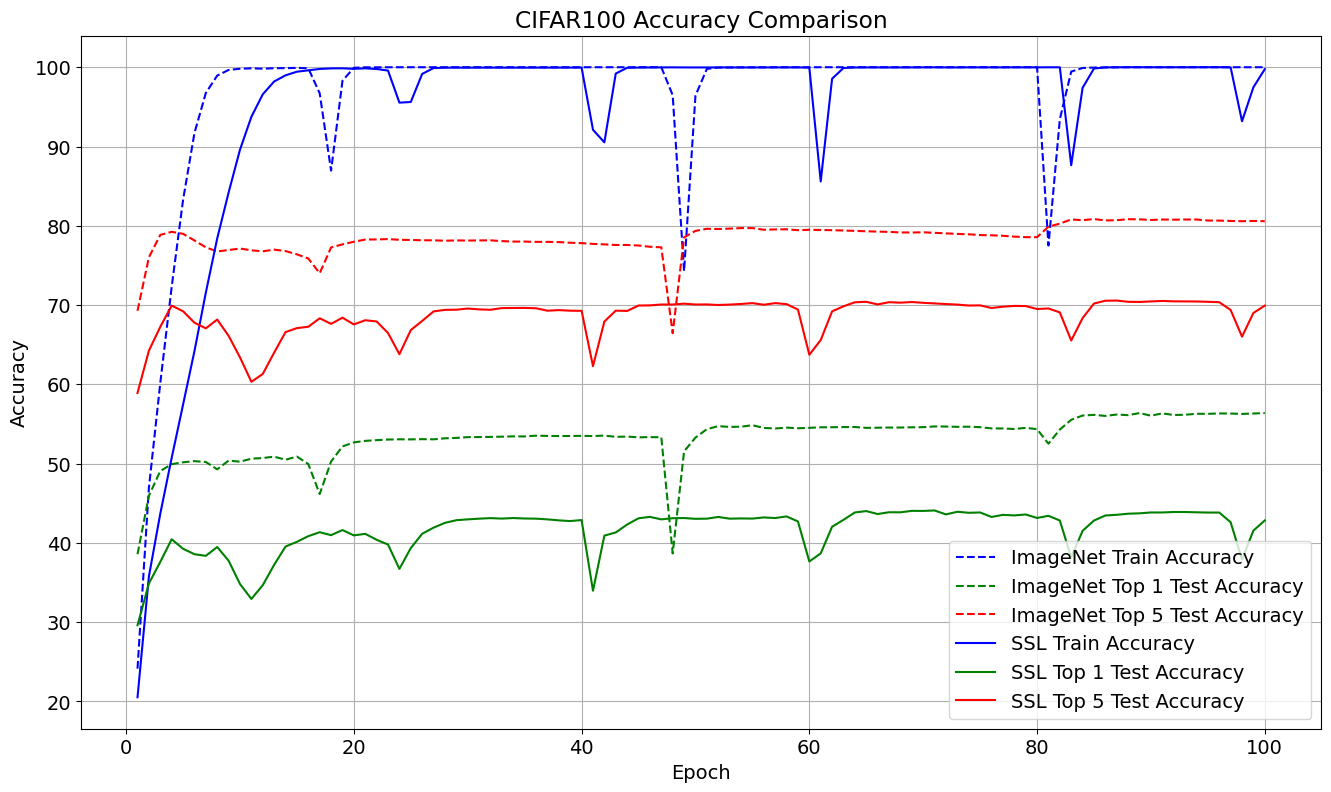

In [ ]:
plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 14})
plt.title('CIFAR100 Accuracy Comparison')
plt.plot(epoch_list, imagenet_top1_train_accuracy, c='b', linestyle='--')
plt.plot(epoch_list, imagenet_top1_test_accuracy, c='g', linestyle='--')
plt.plot(epoch_list, imagenet_top5_test_accuracy, c='r', linestyle='--')
plt.plot(epoch_list, ssl_top1_train_accuracy, c='b')
plt.plot(epoch_list, ssl_top1_test_accuracy, c='g')
plt.plot(epoch_list, ssl_top5_test_accuracy, c='r')
plt.legend(['ImageNet Train Accuracy', 'ImageNet Top 1 Test Accuracy', 'ImageNet Top 5 Test Accuracy',
            'SSL Train Accuracy', 'SSL Top 1 Test Accuracy', 'SSL Top 5 Test Accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()